**Author:** Ahmadreza Attarpour  
**Email:** [a.attarpour@mail.utoronto.ca](mailto:a.attarpour@mail.utoronto.ca)  

This notebook demonstrates MLP model for MNIST image classficaition using PyTorch

---

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np
import argparse
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn.init as init

# 1. Data Preparation

The **MNIST** database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

We split the training set into 50k and 10k of training and validation data sets.

**Data Set**  
$$X_{train} \in \mathcal{R}^{50000 \times 784}, Y_{train} \in \mathcal{Z}^{50000}$$  
$$X_{val} \in \mathcal{R}^{10000 \times 784}, Y_{val} \in \mathcal{Z}^{10000}$$  
$$X_{test} \in \mathcal{R}^{10000 \times 784}, Y_{test} \in \mathcal{Z}^{10000}$$

In [3]:
batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

# print the shape and len of the datasets
print(f"Train dataset shape: {len(train_dataset)}")
print(f"Validation dataset shape: {len(val_dataset)}")
print(f"Test dataset shape: {len(test_dataset)}")



# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:03<00:00, 2.54MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 289kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 593kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.38MB/s]

Train dataset shape: 50000
Validation dataset shape: 10000
Test dataset shape: 10000


## Visualizing dataset

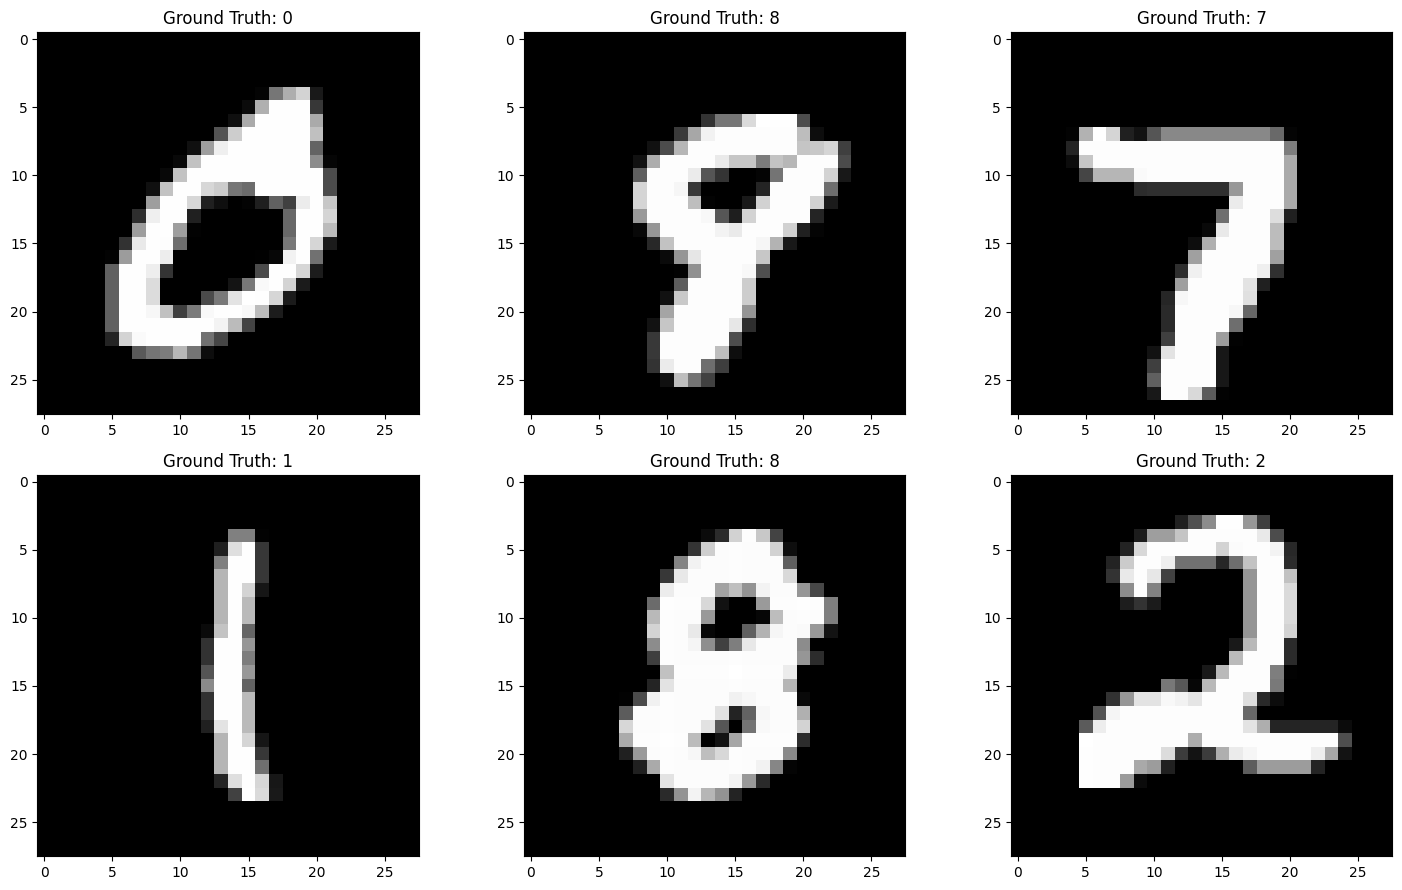

In [ ]:
# Enumerating over the train_loader, which loads batches of the MNIST dataset.
examples = enumerate(train_loader)
# Get the first batch of data
batch_idx, (example_data, example_targets) = next(examples)  

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

# 2. Model Define

In [ ]:

class Mlp(nn.Module):
    """
    A Multi-Layer Perceptron (MLP) model with customizable architecture.

    Args:
        input_dim (int): Number of input features.
        hidden_dim (int): Number of neurons in each hidden layer.
        output_dim (int): Number of output units.
        num_layers (int): Number of hidden layers.
        act_layer (nn.Module, optional): Activation function class (default is nn.ReLU).
        dropout (float, optional): Dropout probability (default is 0.1).
        batch_norm (bool, optional): Whether to apply Batch Normalization (default is False).
        init_weights (bool, optional): Whether to initialize weights using He/Xavier based on activation.
    """

    def __init__(self, input_dim, hidden_dim, output_dim,
                 num_layers, act_layer=nn.ReLU, dropout=0.1,
                 batch_norm=False, init_weights=False):

        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.act_layer = act_layer
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.init_weights = init_weights

        # First layer
        self.fc_in = nn.Linear(input_dim, hidden_dim)

        # Hidden layers and optional batchnorm
        self.hidden_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()

        for _ in range(num_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if batch_norm:
                self.batch_norm_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        # Activation and dropout
        self.act = act_layer()
        self.dropout_layer = nn.Dropout(dropout)

        # Optional initialization
        if self.init_weights:
            self._initialize_weights()

    def _initialize_weights(self):
        """
        Initializes weights using He or Xavier initialization
        depending on the activation function.
        """
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if isinstance(self.act, nn.ReLU):  # Note: `self.act` not `self.act_layer`
                    init.kaiming_normal_(m.weight, nonlinearity='relu')
                elif isinstance(self.act, (nn.Sigmoid, nn.Tanh)):
                    init.xavier_normal_(m.weight)
                else:
                    init.kaiming_normal_(m.weight, nonlinearity='relu')  # Fallback
                if m.bias is not None:
                    init.zeros_(m.bias)

    def forward(self, x):
        x = self.fc_in(x)
        x = self.act(x)
        x = self.dropout_layer(x)
        for i in range(self.num_layers - 1):
            x = self.hidden_layers[i](x)
            x = self.act(x)
            if self.batch_norm:
                x = self.batch_norm_layers[i](x)
            x = self.dropout_layer(x)
        x = self.fc_out(x)
        return x

    



In [16]:
# for macOS users
# Check if MPS (Metal Performance Shaders) is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS device is available.")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU.")

# Check if CUDA is available
# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("CUDA is available.")
# else:
#     device = torch.device("cpu")
#     print("CUDA not found. Using CPU.")

MPS device is available.


# 3. Experiment Design

In [17]:
def run_experiment(args):
    model = Mlp(args.in_dim, args.hid_dim, args.out_dim, args.n_layers, args.act_layer, args.dropout, args.batch_norm, args.init_weights)

    print(model)

    # GPU
    model.to(device)

    # ====== Loss function ====== #
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # ====== Data collection ====== #
    list_epoch = [] 
    list_train_loss = []
    list_val_loss = []
    best_val_loss = float('inf')
    best_epoch = 0

    # ====== Loop ====== #
    for epoch in range(args.epoch):  
        
        # ====== Train ====== #
        model.train() # Set the model be 'train mode' 
        
        # train_loader contains 128 * 1 * 28 * 28 boxes
        train_loss = 0
        for i, (input_X, true_y) in enumerate(train_loader):
            optimizer.zero_grad()

            input_x = input_X.squeeze()
            input_x = input_x.view(-1, 784) # 28x28 = 784

            input_x = input_x.to(device)
            true_y = true_y.to(device)

            pred_y = model(input_x)

            loss = criterion(pred_y.squeeze(), true_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            # print loss for each step
            print(f"Step {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")


        # calculate the train loss for this epoch
        train_loss = train_loss / len(train_loader)
        list_train_loss.append(train_loss)
        list_epoch.append(epoch)

        # print average loss for the epoch
        print(f"Epoch {epoch+1}/{args.epoch}, Average Train Loss: {train_loss:.4f}")

        # ====== Validation ====== #

        if epoch % args.val_interval == 0:
            model.eval() # Set the model be 'val mode' 
            val_loss = 0

            with torch.no_grad():
                for input_X, true_y in val_loader:

                    input_x = input_X.squeeze()
                    input_x = input_x.view(-1, 784) # 28x28 = 784

                    input_x = input_x.to(device)
                    true_y = true_y.to(device)

                    pred_y = model(input_x)

                    loss = criterion(pred_y.squeeze(), true_y)

                    val_loss += loss.item()

                val_loss = val_loss / len(val_loader)
                list_val_loss.append(val_loss)

                # print average loss for the epoch
                print(f"Epoch {epoch+1}/{args.epoch}, Average Validation Loss: {val_loss:.4f}")

                # Save the model if the validation loss is the best so far
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_epoch = epoch
                    best_model = model
                    print(f"Model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")

    return list_epoch, list_train_loss, list_val_loss, best_model
        



# 4. Train & Evaluation

In [24]:
ts = time.time()

seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.in_dim = 784 # 28 * 28
args.out_dim = 10 # number of classes 
args.hid_dim = 200
args.n_layers = 5
args.act_layer = nn.ReLU
args.dropout = 0.1
args.batch_norm = True
args.init_weights = True
args.val_interval = 1

args.lr = 0.005
args.epoch = 25

list_epoch, list_train_loss, list_val_loss, best_model = run_experiment(args)

te = time.time()

print('Elapsed time: {} sec'.format(int(te-ts)))

Mlp(
  (fc_in): Linear(in_features=784, out_features=200, bias=True)
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=200, out_features=200, bias=True)
  )
  (batch_norm_layers): ModuleList(
    (0-3): 4 x BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_out): Linear(in_features=200, out_features=10, bias=True)
  (act): ReLU()
  (dropout_layer): Dropout(p=0.1, inplace=False)
)
Step 1/391, Loss: 3.0929
Step 2/391, Loss: 2.6248
Step 3/391, Loss: 1.8895
Step 4/391, Loss: 1.6496
Step 5/391, Loss: 1.3647
Step 6/391, Loss: 1.3815
Step 7/391, Loss: 1.5041
Step 8/391, Loss: 1.1810
Step 9/391, Loss: 1.0314
Step 10/391, Loss: 1.2071
Step 11/391, Loss: 1.0977
Step 12/391, Loss: 0.8107
Step 13/391, Loss: 0.9822
Step 14/391, Loss: 0.7254
Step 15/391, Loss: 0.7831
Step 16/391, Loss: 0.6334
Step 17/391, Loss: 0.7118
Step 18/391, Loss: 0.6348
Step 19/391, Loss: 0.7158
Step 20/391, Loss: 0.7113
Step 21/391, Loss: 0.6590
Step 22/391, Loss: 0.7402

# 5. Report and test

Text(0.5, 1.0, 'epoch vs loss')

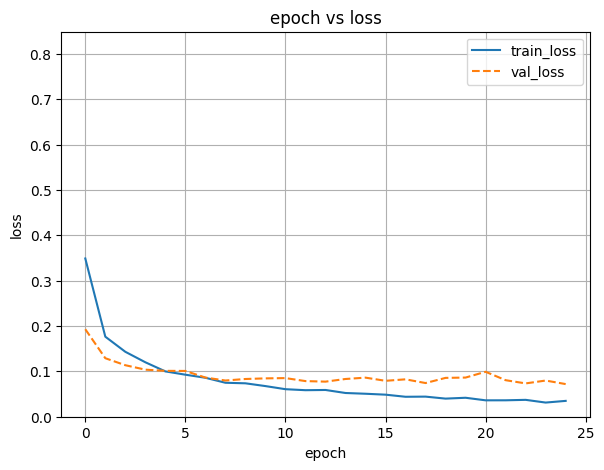

In [27]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.set_ylim(0, max(list_train_loss) + 0.5)
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# 6. Test

In [28]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(f"Example data shape: {example_data.shape}")
print(f"Example targets shape: {example_targets.shape}")

Example data shape: torch.Size([128, 1, 28, 28])
Example targets shape: torch.Size([128])


Accuracy: 1.0000


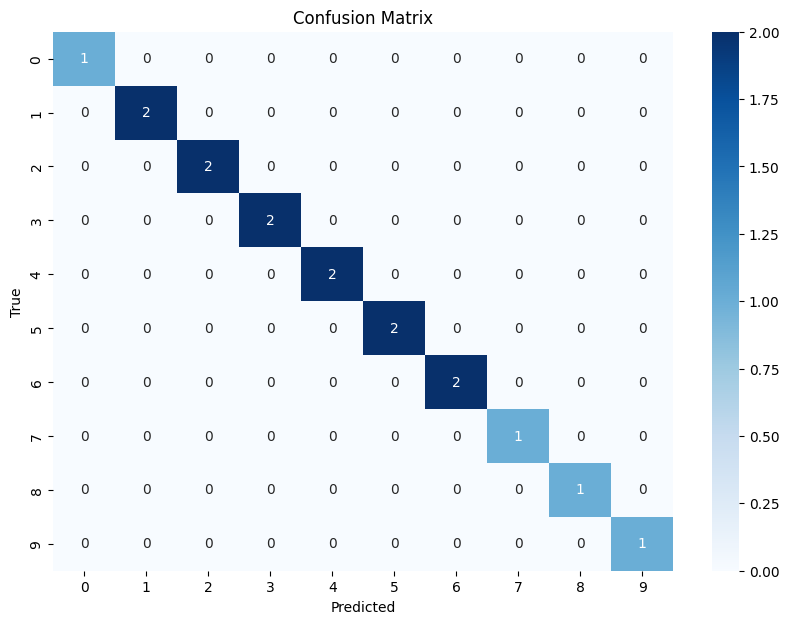

In [ ]:
# test the best model on test

best_model.eval() # Set the model be 'test mode'


all_true_ys = []
all_pred_ys = []

# ====== Test ====== #
with torch.no_grad():

    for input_X, true_y in test_loader:

        input_x = input_X.squeeze()
        input_x = input_x.view(-1, 784)
        input_x = input_x.to(device)
        true_y = true_y.to(device)

        pred_y = best_model(input_x)

        pred_y = torch.argmax(pred_y, dim=1)
        pred_y = pred_y.cpu().numpy()
        true_y = true_y.cpu().numpy()

        # get all the true and predicted labels
        all_true_ys.extend(y for y in true_y)
        all_pred_ys.extend(y for y in pred_y)


    accuracy = accuracy_score(true_y, pred_y)
    print(f"Accuracy: {accuracy:.4f}")

    # plot the confusion matrix
    cm = confusion_matrix(true_y, pred_y)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
